<a href="https://colab.research.google.com/github/vaishnabala/Lending_case_study/blob/master/Telecom_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'telecom-churn-case-study-hackathon-c57:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F71443%2F7811209%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240306%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240306T172500Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2a0c0f262e40c37575ecad1c9928616a307a601fcc8bb54df56b4545de66f0268ce8114df3d8aa0aabb0bc5ea3b2916cd71d55d41a71bdef2119c6587c08ee5de6d99f2bfe981d4e45a43884d9627257face5c8001346aaab10d65452b273330089896994973a4264348b5c104c3c83fcc558852ab5a1102a6feb1211e479e35536f2f6be1be95ec02a0fd545d738504abbbcaed30f62218b88b1054255d4a3c770e82640930e3560617b9bf177ca2d9727a44e9f1326f54cd8065b29c0971c94ad9d9b86cf0bd9ff66aa8f1cd8f8bc309845d8e7ad78162fa521ceb39e4b75d4fcc8941c503acb3edf8075973e33e455ab9e5bc215816d8fd84fe6409934822'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# Problem Statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn.

In this competition, your goal is to build a machine learning model that is able to predict churning customers based on the features provided for their usage.

The following models and techniques are implemented as part of this exercise,
- Logistic Regression
- SVM
- XGB
- Random Forest
- PCA
- HPT with Hyper Opt and Grid search
- SMOTE


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
import statsmodels.api as stats
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import IncrementalPCA
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,auc
from imblearn.metrics import sensitivity_specificity_support
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale


# Displaying all Columns without restrictions
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Understanding the Data

Lets understand the column descriptions by looking at the data dict

In [ ]:
data_dict = pd.read_csv("/kaggle/input/telecom-churn-case-study-hackathon-c57/data_dictionary.csv")
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belongs to
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile to mobile
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


Data Pre-Processing is applied in parallel for the test data in different Dataframe , so that we dont need to handle it seperately

In [ ]:
churn_train=pd.read_csv('/kaggle/input/telecom-churn-case-study-hackathon-c57/train.csv')
churn_test=pd.read_csv('/kaggle/input/telecom-churn-case-study-hackathon-c57/test.csv')
churn_train.head(10)

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.00,0.00,0.00,0.00,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.00,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.00,0.00,0.00,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.00,0.00,0.00,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,

In [ ]:
churn_test.head(10)

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.00,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.00,0.0,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.00,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.00,0.00,0.00,0.0,0.0,0.0,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.00,0.00,0.00,5,5,4,103,90,60,50,30,30,6/21/2014,7/26/2014,8/24/2014,30,30,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.00,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.00,0.0,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.00,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.00,0.00,0.00,5,4,5,500,500,500,250,250,250,6/19/2014,7/16/2014,8/24/2014,2

In [ ]:
# Checking the shape of the dataset
churn_train.shape


(69999, 172)

In [ ]:
churn_test.shape

(30000, 171)

In [ ]:
churn_train.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000

In [ ]:
churn_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

# Missing Values Treatment

Its evident from the describe, some of the columns have only one unique value , having one unique value for all the rows is a constant which wouldnt explain the variance of the data. Hence we can find those columns and remove them

In [ ]:
# Find the columns which has only one unique values
remove_list = []
for i in churn_train.columns:
    if churn_train[i].nunique()==1:
        remove_list.append(i)
print('columns which has only one unique values are : ')
remove_list

columns which has only one unique values are : 


['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8']

In [ ]:
churn_train=churn_train.drop(remove_list,axis=1)
churn_test=churn_test.drop(remove_list,axis=1)
churn_train.shape

(69999, 159)

In [ ]:
churn_test.shape

(30000, 158)

In [ ]:
percent_missing = churn_train.isnull().sum() * 100 / len(churn_train)
print(percent_missing)

arpu_6                 0.000000
arpu_7                 0.000000
arpu_8                 0.000000
onnet_mou_6            3.954342
onnet_mou_7            3.838626
onnet_mou_8            5.290076
offnet_mou_6           3.954342
offnet_mou_7           3.838626
offnet_mou_8           5.290076
roam_ic_mou_6          3.954342
roam_ic_mou_7          3.838626
roam_ic_mou_8          5.290076
roam_og_mou_6          3.954342
roam_og_mou_7          3.838626
roam_og_mou_8          5.290076
loc_og_t2t_mou_6       3.954342
loc_og_t2t_mou_7       3.838626
loc_og_t2t_mou_8       5.290076
loc_og_t2m_mou_6       3.954342
loc_og_t2m_mou_7       3.838626
loc_og_t2m_mou_8       5.290076
loc_og_t2f_mou_6       3.954342
loc_og_t2f_mou_7       3.838626
loc_og_t2f_mou_8       5.290076
loc_og_t2c_mou_6       3.954342
loc_og_t2c_mou_7       3.838626
loc_og_t2c_mou_8       5.290076
loc_og_mou_6           3.954342
loc_og_mou_7           3.838626
loc_og_mou_8           5.290076
std_og_t2t_mou_6       3.954342
std_og_t

The missingness in the dataset can be a feature itself, the variables related to recharge the minimum values can be zero which means no recharge was done. Lets impute zero values to all the columns related to recharge

In [ ]:
reacharge_cols = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
        'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
        'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8'
       ]

churn_train[reacharge_cols] = churn_train[reacharge_cols].apply(lambda x: x.fillna(0))
churn_test[reacharge_cols] = churn_test[reacharge_cols].apply(lambda x: x.fillna(0))
churn_train[reacharge_cols].isnull().sum()*100/churn_train.shape[1]


total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
dtype: float64

In [ ]:
churn_train[reacharge_cols].describe()

,total_rech_data_6,total_rech_data_7,total_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,0.619309,0.683981,0.697867,48.395787,51.415168,51.782975,31.748339,32.260075,32.986614
std,1.762010,1.943193,1.973434,126.923180,133.246541,131.291162,77.519536,78.069163,78.808337
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,8.000000,17.000000,23.000000,8.000000,14.000000,17.000000
max,61.000000,54.000000,60.000000,5920.000000,4365.000000,4076.000000,1555.000000,1555.000000,1555.000000


Drop the duplicates

In [ ]:
churn_train.drop_duplicates(subset=None, inplace=True)
churn_test.drop_duplicates(subset=None, inplace=True)
print(churn_train.shape)
print(churn_test.shape)


(69999, 152)
(30000, 151)


The ID columns and Date columns are not required for the analysis , we can remove them by dropping

In [ ]:
churn_test_id=churn_test['id']
churn_test.set_index('id', inplace=True)



In [ ]:
categories =  ['night_pck_user_6',
             'night_pck_user_7',
             'night_pck_user_8',
             'fb_user_6',
             'fb_user_7',
             'fb_user_8'
            ]
for i in categories:
    print(churn_train[i].value_counts())

# Imputinng '-1' for thr missing values in categorical columns
churn_train[categories] = churn_train[categories].apply(lambda x: x.fillna(-1))
churn_test[categories] = churn_test[categories].apply(lambda x: x.fillna(-1))

print(churn_train[categories].isnull().sum()*100/churn_train.shape[0])


night_pck_user_6
0.0    17124
1.0      444
Name: count, dtype: int64
night_pck_user_7
0.0    17435
1.0      430
Name: count, dtype: int64
night_pck_user_8
0.0    18030
1.0      387
Name: count, dtype: int64
fb_user_6
1.0    16098
0.0     1470
Name: count, dtype: int64
fb_user_7
1.0    16249
0.0     1616
Name: count, dtype: int64
fb_user_8
1.0    16397
0.0     2020
Name: count, dtype: int64
night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64


For a wider dataset where we have more columns, manually inspecting and removing the columns with more missing values is unrealistic, the programatic approch is to set the tolreance and remove the missing values based on the tolerance. For example ,Lets say 30% is the tolreance used for this dataset which means the column has 70% null values , the column with 70 % null values will be removed and considered as invalid feature

In [ ]:

def removecols_missingvalues(df,tolerance=0.3):
    """
    The function takes Dataframe as input
    Based the given tolreance of missing values in the given column , the columns are removed
    Default tolerance is 30% which means columns which has 70% missing values will be dropped
    returns new dataframe with dropped columns
    """
    l = len(df)
    dropcols = []
    df2 = df[[column for column in df if df[column].count() / l >= tolerance]]

    print("List of dropped columns:", end=" ")
    for c in df.columns:
        if c not in df2.columns:
            dropcols.append(c)
            print(f"column {c} is discarded because it has only {((df[c].count())/l)*100} % valid values!")
    print('\n')

    df = df2
    return df

churn_train = removecols_missingvalues(churn_train)

List of dropped columns: column count_rech_2g_6 is discarded because it has only 25.097501392877042 % valid values!
column count_rech_2g_7 is discarded because it has only 25.521793168473835 % valid values!
column count_rech_2g_8 is discarded because it has only 26.31037586251232 % valid values!
column count_rech_3g_6 is discarded because it has only 25.097501392877042 % valid values!
column count_rech_3g_7 is discarded because it has only 25.521793168473835 % valid values!
column count_rech_3g_8 is discarded because it has only 26.31037586251232 % valid values!
column arpu_3g_6 is discarded because it has only 25.097501392877042 % valid values!
column arpu_3g_7 is discarded because it has only 25.521793168473835 % valid values!
column arpu_3g_8 is discarded because it has only 26.31037586251232 % valid values!
column arpu_2g_6 is discarded because it has only 25.097501392877042 % valid values!
column arpu_2g_7 is discarded because it has only 25.521793168473835 % valid values!
column 

In [ ]:
churn_test = churn_test.drop(['count_rech_2g_6','count_rech_2g_7','count_rech_2g_8','count_rech_3g_6','count_rech_3g_7','count_rech_3g_8','arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8'],axis=1)

Lets impute the median values for the numerical columns

In [ ]:
numerical_features = [
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou_7',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2f_mou_6',
 'loc_ic_t2f_mou_7',
 'loc_ic_t2f_mou_8',
 'loc_ic_mou_6',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'std_ic_t2t_mou_6',
 'std_ic_t2t_mou_7',
 'std_ic_t2t_mou_8',
 'std_ic_t2m_mou_6',
 'std_ic_t2m_mou_7',
 'std_ic_t2m_mou_8',
 'std_ic_t2f_mou_6',
 'std_ic_t2f_mou_7',
 'std_ic_t2f_mou_8',
 'std_ic_mou_6',
 'std_ic_mou_7',
 'std_ic_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8',
 'spl_ic_mou_6',
 'spl_ic_mou_7',
 'spl_ic_mou_8',
 'isd_ic_mou_6',
 'isd_ic_mou_7',
 'isd_ic_mou_8',
 'ic_others_6',
 'ic_others_7',
 'ic_others_8',
 'total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'last_day_rch_amt_6',
 'last_day_rch_amt_7',
 'last_day_rch_amt_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'vol_2g_mb_6',
 'vol_2g_mb_7',
 'vol_2g_mb_8',
 'vol_3g_mb_6',
 'vol_3g_mb_7',
 'vol_3g_mb_8',
 'monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'sachet_2g_6',
 'sachet_2g_7',
 'sachet_2g_8',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8',
 'sachet_3g_6',
 'sachet_3g_7',
 'sachet_3g_8',
 'aon',
 'aug_vbc_3g',
 'jul_vbc_3g',
 'jun_vbc_3g',
 'churn_probability']

churn_train[numerical_features] = churn_train[numerical_features].apply(lambda x: x.fillna(x.median()))
numerical_features.remove('churn_probability')
churn_test[numerical_features] = churn_test[numerical_features].apply(lambda x: x.fillna(x.median()))



In [ ]:
churn_train.isnull().sum()*100/churn_train.shape[0]

arpu_6                0.0
arpu_7                0.0
arpu_8                0.0
onnet_mou_6           0.0
onnet_mou_7           0.0
onnet_mou_8           0.0
offnet_mou_6          0.0
offnet_mou_7          0.0
offnet_mou_8          0.0
roam_ic_mou_6         0.0
roam_ic_mou_7         0.0
roam_ic_mou_8         0.0
roam_og_mou_6         0.0
roam_og_mou_7         0.0
roam_og_mou_8         0.0
loc_og_t2t_mou_6      0.0
loc_og_t2t_mou_7      0.0
loc_og_t2t_mou_8      0.0
loc_og_t2m_mou_6      0.0
loc_og_t2m_mou_7      0.0
loc_og_t2m_mou_8      0.0
loc_og_t2f_mou_6      0.0
loc_og_t2f_mou_7      0.0
loc_og_t2f_mou_8      0.0
loc_og_t2c_mou_6      0.0
loc_og_t2c_mou_7      0.0
loc_og_t2c_mou_8      0.0
loc_og_mou_6          0.0
loc_og_mou_7          0.0
loc_og_mou_8          0.0
std_og_t2t_mou_6      0.0
std_og_t2t_mou_7      0.0
std_og_t2t_mou_8      0.0
std_og_t2m_mou_6      0.0
std_og_t2m_mou_7      0.0
std_og_t2m_mou_8      0.0
std_og_t2f_mou_6      0.0
std_og_t2f_mou_7      0.0
std_og_t2f_m

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

Derive the column to find Total data recharge value for June and July which would help us to find the churn

In [ ]:
#Focus is only the high value customers
# Total Data Recharge Amt = total_rech_data_6 * av_rech_amt_data_6

churn_train['total_data_rech_6'] = churn_train.total_rech_data_6 * churn_train.av_rech_amt_data_6
churn_train['total_data_rech_7'] = churn_train.total_rech_data_7 * churn_train.av_rech_amt_data_7

#Applying the same for test dataset
churn_test['total_data_rech_6'] = churn_test.total_rech_data_6 * churn_test.av_rech_amt_data_6
churn_test['total_data_rech_7'] = churn_test.total_rech_data_7 * churn_test.av_rech_amt_data_7

#  Total recharge amount = call recharge amount + data recharge amount
churn_train['amt_data_6'] = churn_train.total_rech_amt_6 + churn_train.total_data_rech_6
churn_train['amt_data_7'] = churn_train.total_rech_amt_7 + churn_train.total_data_rech_7

# calculate average recharge done by customer in June and July
churn_train['av_amt_data_6_7'] = (churn_train.amt_data_6 + churn_train.amt_data_7)/2

#Applying the above calc for test
#  Total recharge amount = call recharge amount + data recharge amount
churn_test['amt_data_6'] = churn_test.total_rech_amt_6 + churn_test.total_data_rech_6
churn_test['amt_data_7'] = churn_test.total_rech_amt_7 + churn_test.total_data_rech_7

# calculate average recharge done by customer in June and July
churn_test['av_amt_data_6_7'] = (churn_test.amt_data_6 + churn_test.amt_data_7)/2

Lets Understand the distribution of Average recharge amount for June and July

In [ ]:
# Define the desired percentiles
percentiles = [25, 50, 75, 80]

# Calculate percentiles using numpy.percentile
percentile_values = np.percentile(churn_train['av_amt_data_6_7'], percentiles)

print(f" Percentiles {percentiles}: {percentile_values}")


 Percentiles [25, 50, 75, 80]: [128.  275.5 553.  656. ]


We are worried only about the 20% of the high value customers who is likely to get churned compared to the rest of the dataset, so lets fix 80% as a percentile and the criteria for high value customers is 656 as Average recharge amount

In [ ]:
churn_train_filtered = churn_train.loc[churn_train.av_amt_data_6_7 >= churn_train.av_amt_data_6_7.quantile(0.8), :]
churn_train_filtered.shape

(14002, 145)

In [ ]:
churn_train_filtered = churn_train_filtered.reset_index(drop=True)


To derive the Churn phase , 8th month data will be utilised

Churn phase is calculate with the help of the following attributes - total_ic_mou_8, total_og_mou_8, vol_2g_mb_8, and vol_3g_mb_8

**In short, the total num of incoming calls, outgoing calls and volume of the data usage qualifies the churn criteria**

#EDA

churn_probability
0    92.001143
1     7.998857
Name: count, dtype: float64


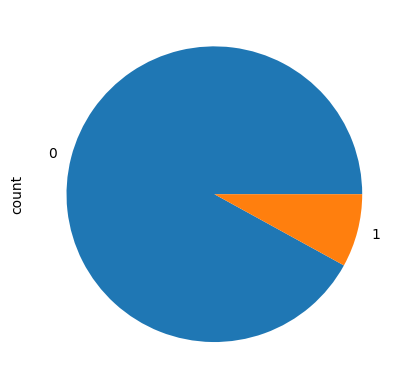

In [ ]:
# Attributes to derive the churn variable
churn_features=['total_ic_mou_8','total_og_mou_8','vol_2g_mb_8','vol_3g_mb_8']

print((churn_train_filtered['churn_probability'].value_counts()/len(churn_train_filtered))*100)
((churn_train_filtered['churn_probability'].value_counts()/len(churn_train_filtered))*100).plot(kind="pie")
plt.show()

Only 8% of the data falls under Churned customers , the dataset is heavily skewed on non-churn customers , this would create bias in model output

The target variable is churn_probability, so the features related to target variables can be dropped , which is the features has suffix as 8

In [ ]:
churn_cols_month_8 = [col for col in churn_train_filtered.columns if '_8' in col]
print(churn_cols_month_8)

churn_train_filtered.drop(churn_cols_month_8, axis=1, inplace=True)

churn_test.drop(churn_cols_month_8, axis=1, inplace=True)


['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_8', 'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_mou_8', 'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'total_rech_data_8', 'max_rech_data_8', 'av_rech_amt_data_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'night_pck_user_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'fb_user_8']


In [ ]:
churn_train_filtered.shape

(14002, 100)

The columns used to derive the average amount can be dropped



In [ ]:
churn_train_filtered.drop(['av_rech_amt_data_6',
                   'total_rech_data_6','total_rech_amt_6',
                  'av_rech_amt_data_7',
                   'total_rech_data_7','total_rech_amt_7'], axis=1, inplace=True)

churn_test.drop(['av_rech_amt_data_6',
                   'total_rech_data_6','total_rech_amt_6',
                  'av_rech_amt_data_7',
                   'total_rech_data_7','total_rech_amt_7'], axis=1, inplace=True)

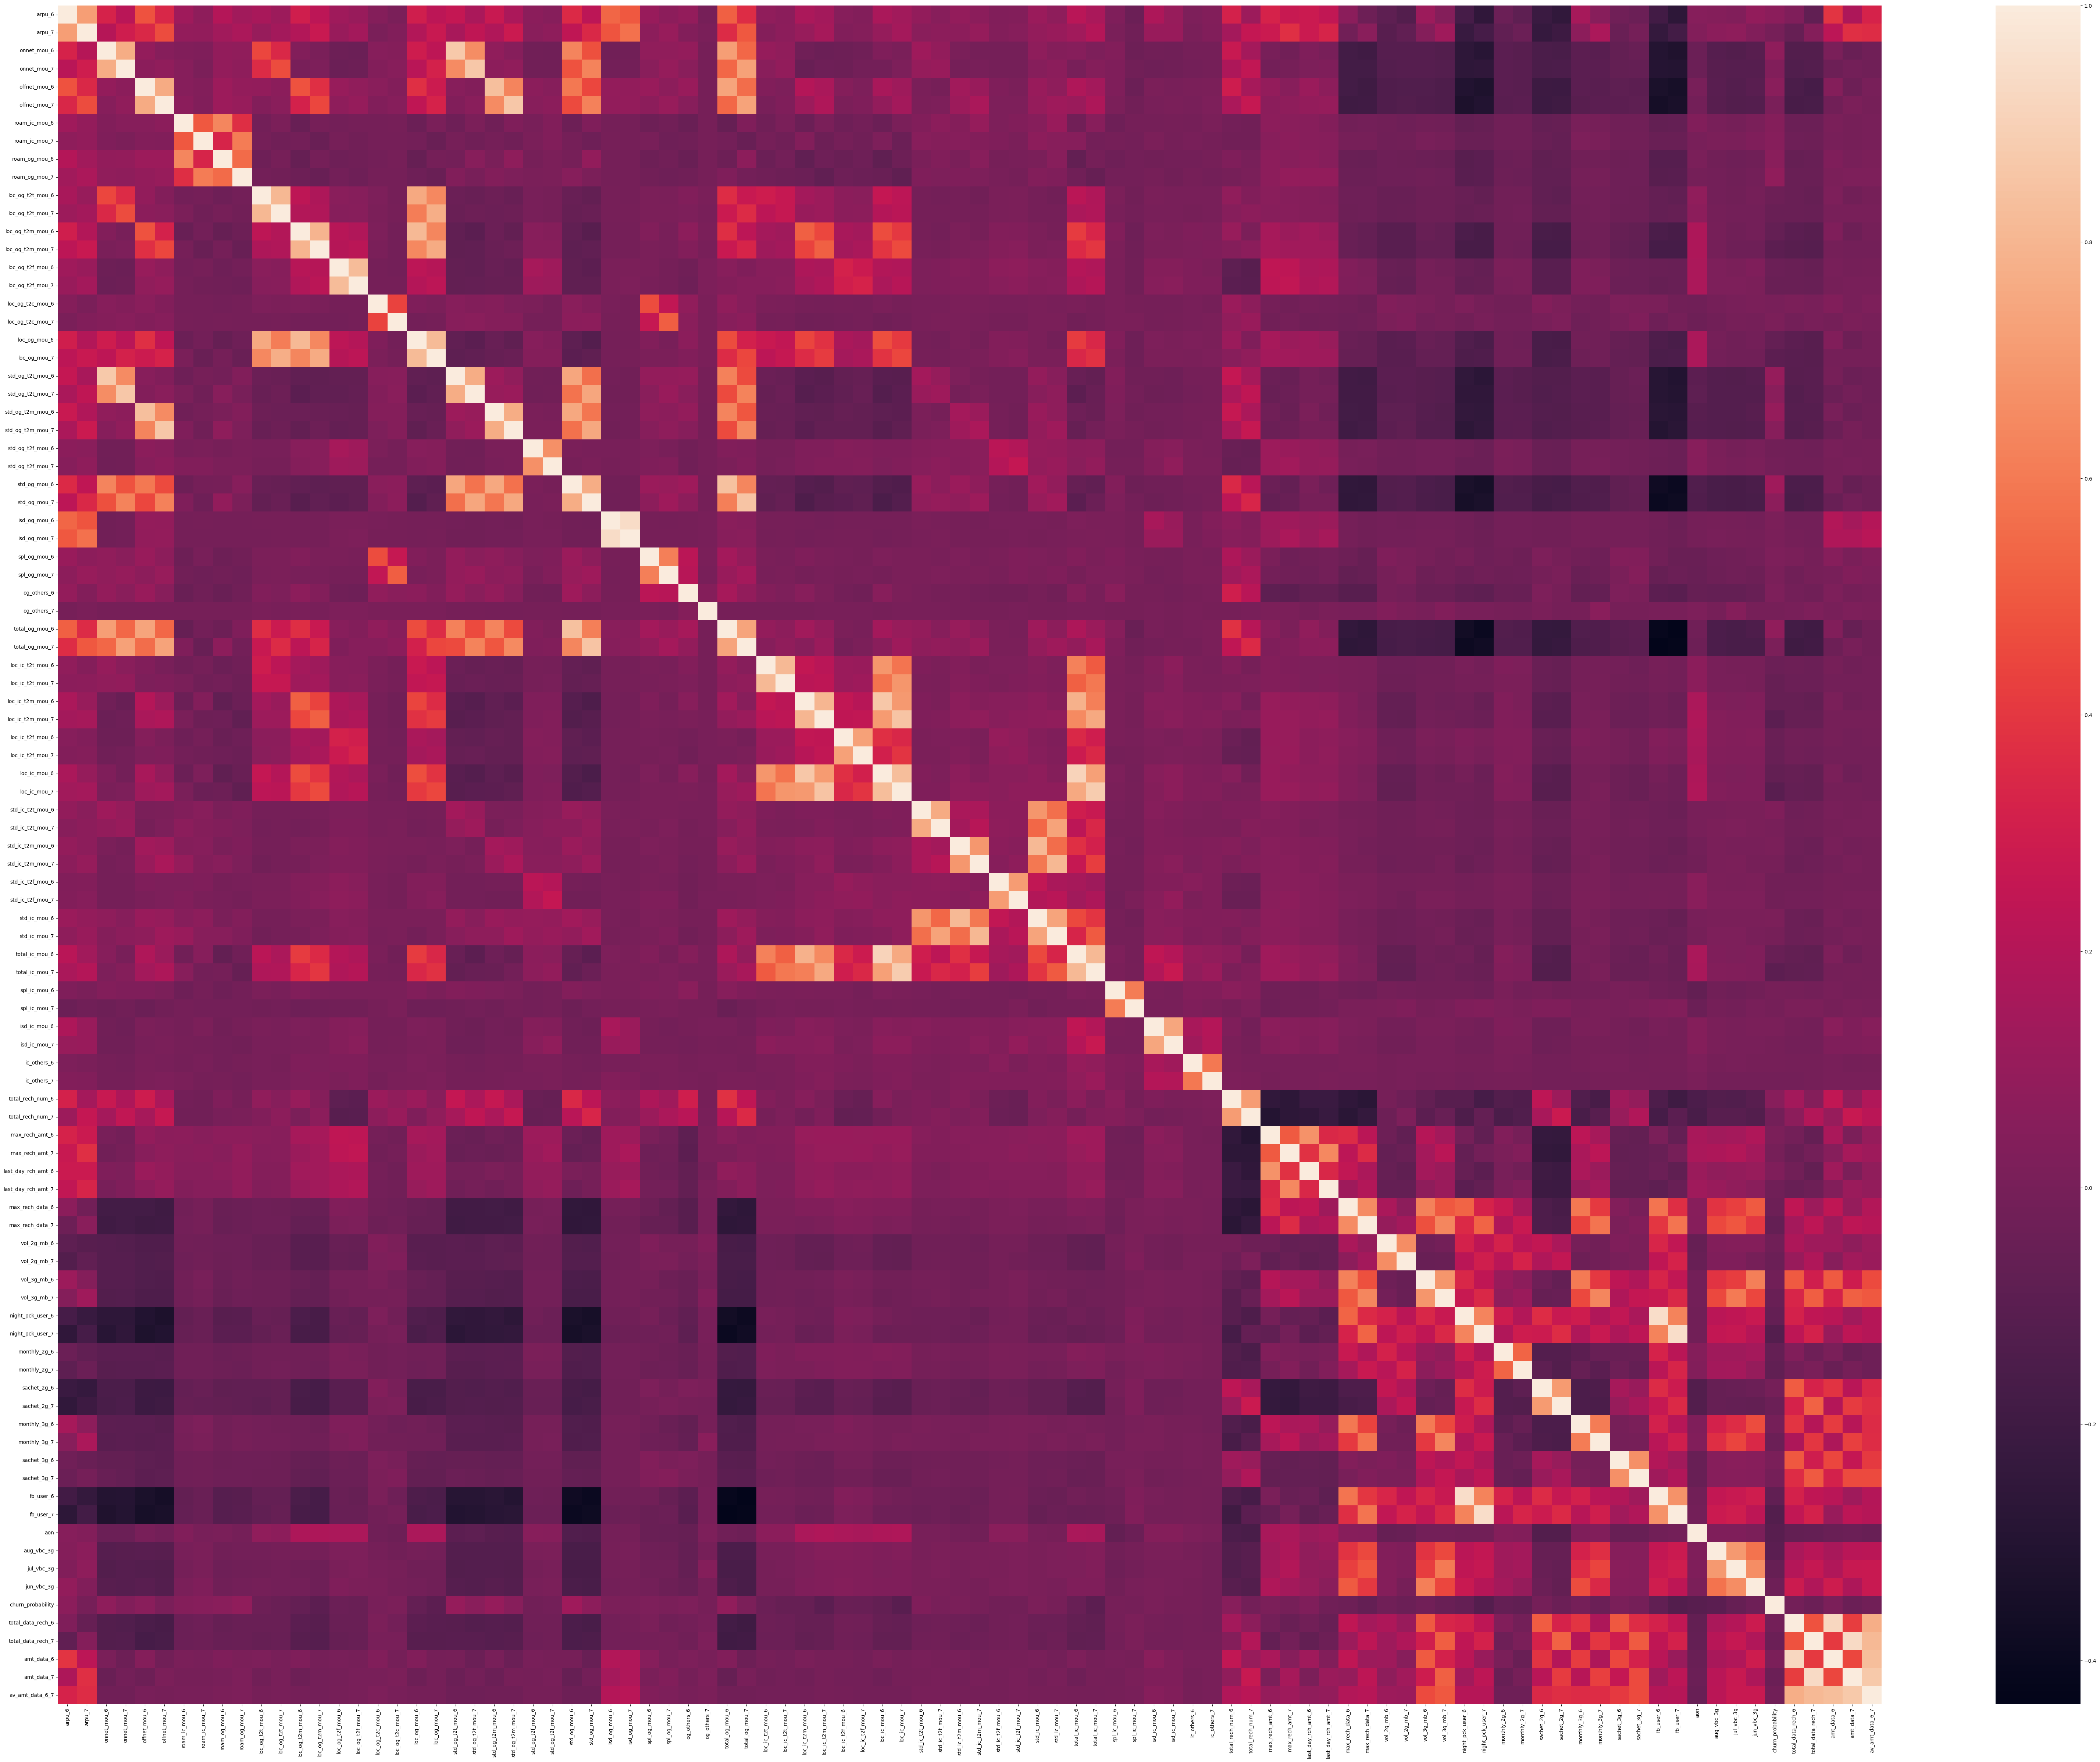

In [ ]:
plt.figure(figsize = (80, 60))
sns.heatmap(churn_train_filtered.select_dtypes(include = ['int64','float64']).corr())
plt.show()

The heatmap is very hard to interpret because of the number of variables, so we can use the below table to understand the correlation

The below colour coding maynot be visible in some environments

In [ ]:
churn_train_filtered.select_dtypes(include = ['int64','float64']).corr().style.background_gradient(cmap='Blues')


In [ ]:

# Create correlation matrix
corr_matrix = churn_train_filtered.select_dtypes(include=['number']).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

set(to_drop)

{'amt_data_6',
 'amt_data_7',
 'av_amt_data_6_7',
 'fb_user_6',
 'fb_user_7',
 'isd_og_mou_7',
 'loc_ic_mou_6',
 'loc_ic_mou_7',
 'loc_ic_t2m_mou_7',
 'loc_ic_t2t_mou_7',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_t2f_mou_7',
 'loc_og_t2t_mou_7',
 'std_ic_mou_6',
 'std_ic_mou_7',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_og_mou_6',
 'total_og_mou_7'}

In [ ]:
churn_train_filtered.drop(set(to_drop),axis=1)
churn_test.drop(set(to_drop),axis=1)


In [ ]:
print(churn_train_filtered.shape)
print(churn_test.shape)

(14002, 94)
(30000, 93)


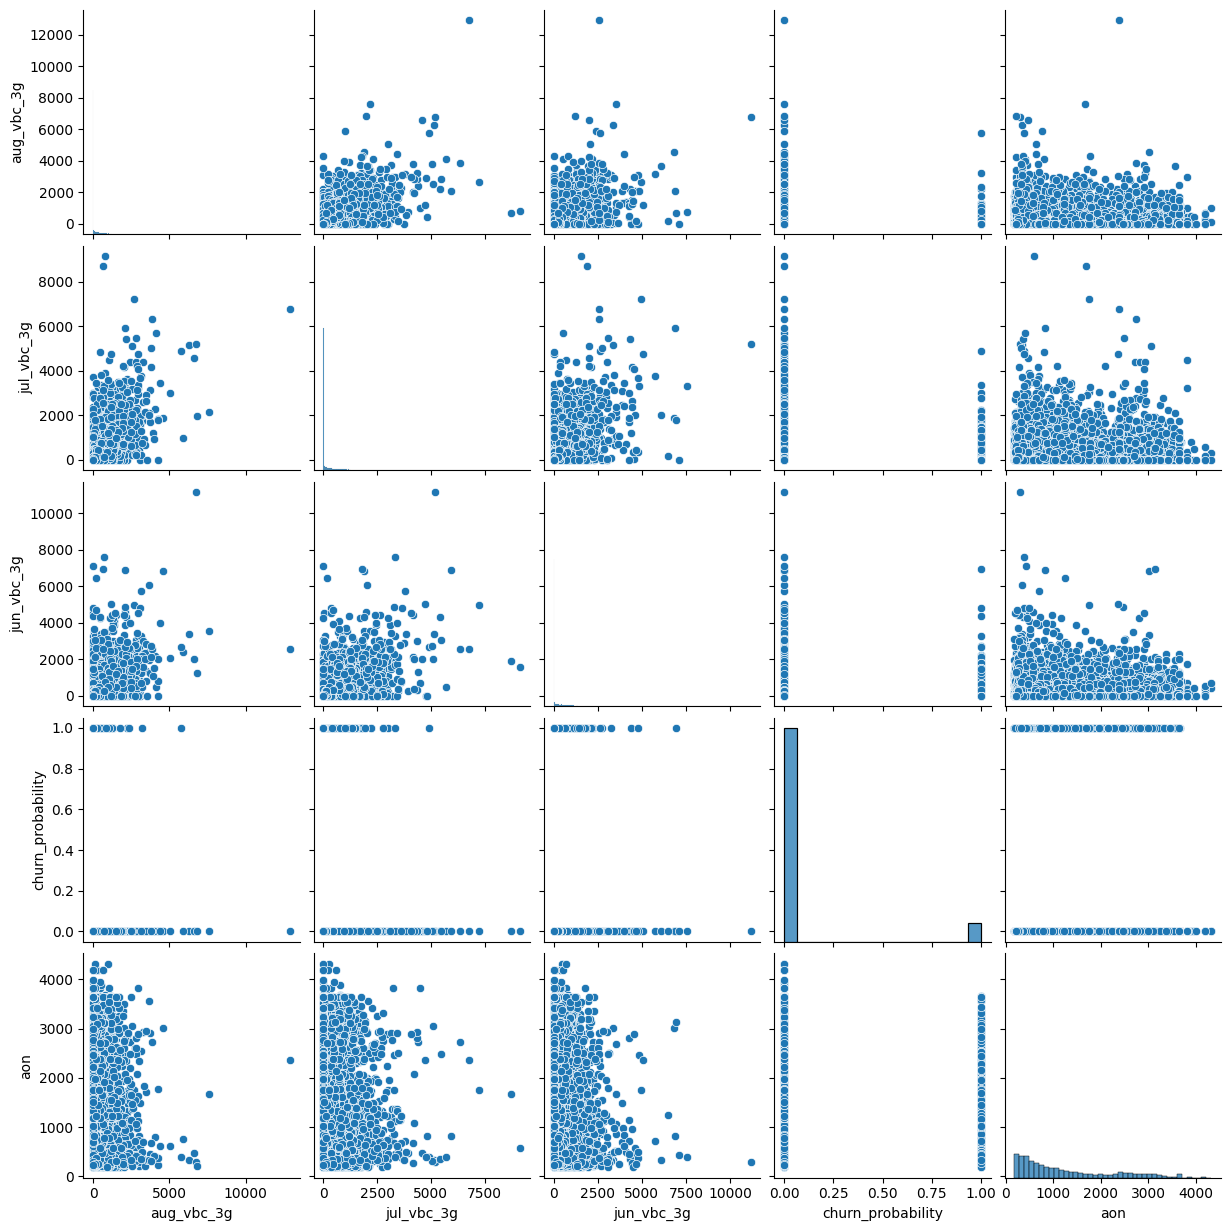

In [ ]:
cols=['aug_vbc_3g','jul_vbc_3g','jun_vbc_3g','churn_probability','aon']
sns.pairplot(churn_train_filtered[cols])
plt.show()

We can observed skewness in churn vs non-churn across all the above variables

In [ ]:
train_cols=churn_train_filtered.columns.to_list()
test_cols=churn_test.columns.to_list()
train_cols.remove('churn_probability')

In [ ]:
churn_test_filtered=churn_test[train_cols]
churn_test_filtered.head(2)

,arpu_6,arpu_7,onnet_mou_6,onnet_mou_7,offnet_mou_6,offnet_mou_7,roam_ic_mou_6,roam_ic_mou_7,roam_og_mou_6,roam_og_mou_7,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_mou_6,loc_og_mou_7,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_mou_6,std_og_mou_7,isd_og_mou_6,isd_og_mou_7,spl_og_mou_6,spl_og_mou_7,og_others_6,og_others_7,total_og_mou_6,total_og_mou_7,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_mou_6,loc_ic_mou_7,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_mou_6,std_ic_mou_7,total_ic_mou_6,total_ic_mou_7,spl_ic_mou_6,spl_ic_mou_7,isd_ic_mou_6,isd_ic_mou_7,ic_others_6,ic_others_7,total_rech_num_6,total_rech_num_7,max_rech_amt_6,max_rech_amt_7,last_day_rch_amt_6,last_day_rch_amt_7,max_rech_data_6,max_rech_data_7,vol_2g_mb_6,vol_2g_mb_7,vol_3g_mb_6,vol_3g_mb_7,night_pck_user_6,night_pck_user_7,monthly_2g_6,monthly_2g_7,sachet_2g_6,sachet_2g_7,monthly_3g_6,monthly_3g_7,sachet_3g_6,sachet_3g_7,fb_user_6,fb_user_7,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_data_rech_6,total_data_rech_7,amt_data_6,amt_data_7,av_amt_data_6_7
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69999,91.882,65.330,31.78,20.23,60.16,32.16,0.0,0.0,0.0,0.0,24.88,20.23,18.13,10.89,0.00,13.58,0.0,0.0,43.01,44.71,6.9,0.0,42.03,7.68,0.0,0.0,48.93,7.68,0.0,0.0,0.0,0.0,0.0,0.0,91.94,52.39,30.33,37.56,10.21,4.59,0.26,0.0,40.81,42.16,0.0,0.0,0.36,1.04,0.0,0.0,0.36,1.04,41.73,43.56,0.54,0.34,0.00,0.00,0.0,0.0,5,5,50,30,30,30,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0,0,0,0,0,0,0,0,-1.0,-1.0,1692,0.0,0.0,0.0,0.0,0.0,103.0,90.0,96.5
70000,414.168,515.568,75.51,41.21,474.34,621.84,0.0,0.0,0.0,0.0,75.51,41.21,473.61,598.08,0.73,0.00,0.0,0.0,549.86,639.29,0.0,0.0,0.00,23.76,0.0,0.0,0.00,23.76,0.0,0.0,0.0,0.0,0.0,0.0,549.86,663.06,19.99,26.95,160.19,122.29,1.49,0.0,181.69,149.24,0.0,0.0,0.00,12.51,0.0,0.0,0.00,12.51,296.33,339.64,0.00,0.00,114.63,177.88,0.0,0.0,5,4,250,250,250,0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0,0,0,0,0,0,0,0,-1.0,-1.0,2533,0.0,0.0,0.0,0.0,0.0,500.0,500.0,500.0


In [ ]:
print(churn_train_filtered.shape)
print(churn_test_filtered.shape)

(14002, 94)
(30000, 93)


#Building Models


In [ ]:
X = churn_train_filtered.drop("churn_probability", axis = 1)
y = churn_train_filtered.churn_probability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 5, stratify = y)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10501, 93)
(10501,)
(3501, 93)
(3501,)


The data is scattereted in different scale among the columns, so scaling has to be performed. All the pre-processsing is performed to the test dataset in parallel

In [ ]:
from sklearn import preprocessing
scaler = MinMaxScaler()
numerical_features=X_train.select_dtypes(include = ['int64','float64']).columns.tolist()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])
churn_test_filtered[numerical_features] = scaler.transform(churn_test_filtered[numerical_features])

In [ ]:
X_train.head(10)

,arpu_6,arpu_7,onnet_mou_6,onnet_mou_7,offnet_mou_6,offnet_mou_7,roam_ic_mou_6,roam_ic_mou_7,roam_og_mou_6,roam_og_mou_7,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_mou_6,loc_og_mou_7,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_mou_6,std_og_mou_7,isd_og_mou_6,isd_og_mou_7,spl_og_mou_6,spl_og_mou_7,og_others_6,og_others_7,total_og_mou_6,total_og_mou_7,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_mou_6,loc_ic_mou_7,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_mou_6,std_ic_mou_7,total_ic_mou_6,total_ic_mou_7,spl_ic_mou_6,spl_ic_mou_7,isd_ic_mou_6,isd_ic_mou_7,ic_others_6,ic_others_7,total_rech_num_6,total_rech_num_7,max_rech_amt_6,max_rech_amt_7,last_day_rch_amt_6,last_day_rch_amt_7,max_rech_data_6,max_rech_data_7,vol_2g_mb_6,vol_2g_mb_7,vol_3g_mb_6,vol_3g_mb_7,night_pck_user_6,night_pck_user_7,monthly_2g_6,monthly_2g_7,sachet_2g_6,sachet_2g_7,monthly_3g_6,monthly_3g_7,sachet_3g_6,sachet_3g_7,fb_user_6,fb_user_7,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_data_rech_6,total_data_rech_7,amt_data_6,amt_data_7,av_amt_data_6_7
596,0.099884,0.036437,0.003729,0.000105,0.003735,0.000033,0.000000,0.000000,0.000000,0.000000,0.004515,0.000109,0.006383,0.000050,0.000000,0.000000,0.000000,0.000000,0.009343,0.000137,0.000000,0.000000,0.000149,0.000000,0.000000,0.000000,0.000147,0.000000,0.000000,0.0,0.000010,0.000000,0.000000,0.0,0.006922,0.000128,0.004638,0.005052,0.018678,0.011333,0.000823,0.000000,0.014019,0.011264,0.000000,0.000000,0.000376,0.000426,0.000000,0.000000,0.000346,0.000219,0.014306,0.009111,0.020749,0.0,0.000000,0.000000,0.006981,0.004205,0.076471,0.028986,0.062843,0.014194,0.007481,0.014194,0.162058,0.000000,0.004969,0.000000,0.054272,0.000000,0.5,0.0,0.00,0.0,0.000000,0.000000,0.222222,0.0,0.000000,0.000000,1.0,0.0,0.159382,0.000000,0.000000,0.087512,0.018229,0.000000,0.032178,0.000785,0.008004
13381,0.099999,0.053610,0.010145,0.016118,0.057996,0.063694,0.023576,0.021873,0.047326,0.064146,0.004339,0.008609,0.036095,0.063215,0.000000,0.002721,0.000000,0.000000,0.031850,0.046052,0.005461,0.002873,0.017797,0.002787,0.000000,0.010584,0.022318,0.005909,0.000005,0.0,0.000195,0.005562,0.080313,0.0,0.045991,0.048946,0.003898,0.010300,0.026564,0.037561,0.000000,0.000284,0.018142,0.033304,0.001293,0.003372,0.004610,0.024438,0.000000,0.000423,0.005240,0.014999,0.021456,0.039583,0.027328,0.0,0.000014,0.001097,0.015583,0.004091,0.111765,0.130435,0.027431,0.035484,0.010973,0.016129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.745472,0.000000,0.000000,0.000000,0.000000,0.000000,0.015588,0.013732,0.004851
5190,0.080474,0.039642,0.000000,0.000579,0.001122,0.002574,0.000000,0.000000,0.000000,0.000000,0.000000,0.000605,0.001997,0.003978,0.000000,0.000000,0.000000,0.000000,0.001524,0.002946,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.001580,0.000000,0.0,0.001105,0.002992,0.000319,0.001092,0.025005,0.031944,0.000218,0.001310,0.015157,0.023679,0.000000,0.000000,0.000000,0.000000,0.000000,0.009621,0.000000,0.001620,0.014691,0.019472,0.000000,0.0,0.000168,0.000000,0.000000,0.000000,0.017647,0.036232,0.037905,0.049032,0.037905,0.049032,0.097749,0.097749,0.000053,0.000051,0.008275,0.023325,0.5,0.5,0.00,0.0,0.023810,0.020833,0.000000,0.0,0.034483,0.030303,1.0,1.0,0.228689,0.004717,0.000000,0.000000,0.010995,0.011038,0.013652,0.014088,0.003611
448,0.082108,0.045180,0.003214,0.001390,0.005167,0.015831,0.000000,0.000000,0.000000,0.000000,0.003891,0.001454,0.005634,0.021222,0.000000,0.000000,0.000000,0.000000,0.008155,0.014004,0.000000,0.000000,0.002013,0.001036,0.000000,0.001095,0.001985,0.000947,0.000000,0.0,0.000000,0.007071,0.000000

**SMOTE**
One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.



In [ ]:
sm = SMOTE(random_state=100)
X_train_sm,y_train_sm = sm.fit_resample(X_train,y_train)

In [ ]:
print(X_train_sm.shape)
print(y_train_sm.shape)

(19322, 93)
(19322,)


Lets Start building the models, Logistic Regression is built as a first baseline model

In [ ]:
# Logistic regression model
lr1 = stats.GLM(y_train_sm,(stats.add_constant(X_train_sm)), family = stats.families.Binomial())
lr1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                19322
Model:                            GLM   Df Residuals:                    19229
Model Family:                Binomial   Df Model:                           92
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10297.
Date:                Wed, 06 Mar 2024   Deviance:                       20594.
Time:                        16:56:21   Pearson chi2:                 2.47e+04
No. Iterations:                   100   Pseudo R-squ. (CS):             0.2742
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0967      0.499      0.194      0.847      -0.882       1.075
arpu_6                 3.5790      4.833      0.741      0.459      -5.893      13.051
arpu_7                13.0841      5.635      2.322      0.020       2.040      24.128
onnet_mou_6          -60.7791     21.883     -2.777      0.005    -103.670     -17.889
onnet_mou_7          -15.2491     19.190     -0.795      0.427     -52.860      22.362
offnet_mou_6         -65.0126     24.437     -2.660      0.008    -112.908     -17.117
offnet_mou_7         -22.7010     16.632     -1.365      0.172     -55.298       9.896
roam_ic_mou_6         -0.2136      0.981     -0.218      0.828      -2.135       1.708
roam_ic_mou_7         -0.8405      1.060     -0.793      0.428      -2.918       1.237
roam_og_mou_6         30.5253     11.126      2.744      0.006       8.719      52.332
roam_og_mou_7         12.0662      6.744      1.789      0.074      -1.151      25.284
loc_og_t2t_mou_6   -6.858e+04   2.06e+04     -3.324      0.001   -1.09e+05   -2.81e+04
loc_og_t2t_mou_7   -7625.0549   2.45e+04     -0.311      0.756   -5.57e+04    4.04e+04
loc_og_t2m_mou_6   -5.287e+04   1.59e+04     -3.324      0.001    -8.4e+04   -2.17e+04
loc_og_t2m_mou_7   -4689.0710   1.51e+04     -0.311      0.756   -3.43e+04    2.49e+04
loc_og_t2f_mou_6   -6421.2861   1931.627     -3.324      0.001   -1.02e+04   -2635.368
loc_og_t2f_mou_7    -621.4049   1997.178     -0.311      0.756   -4535.802    3292.992
loc_og_t2c_mou_6      -5.2626      0.829     -6.348      0.000      -6.887      -3.638
loc_og_t2c_mou_7       4.5397      1.328      3.419      0.001       1.937       7.142
loc_og_mou_6        6245.0053   2.33e+04      0.268      0.789   -3.95e+04    5.19e+04
loc_og_mou_7       -1.987e+04   3.05e+04     -0.651      0.515   -7.97e+04       4e+04
std_og_t2t_mou_6   -9.966e+04      3e+04     -3.322      0.001   -1.58e+05   -4.09e+04
std_og_t2t_mou_7   -1.295e+05   2.99e+04     -4.329      0.000   -1.88e+05   -7.09e+04
std_og_t2m_mou_6   -1.125e+05   3.39e+04     -3.322      0.001   -1.79e+05   -4.61e+04
std_og_t2m_mou_7     -1.1e+05   2.54e+04     -4.329      0.000    -1.6e+05   -6.02e+04
std_og_t2f_mou_6   -8507.7473   2560.245     -3.323      0.001   -1.35e+04   -3489.760
std_og_t2f_mou_7   -8518.9165   1967.750     -4.329      0.000   -1.24e+04   -4662.197
std_og_mou_6        2.774e+04   3.72e+04      0.745      0.456   -4.52e+04    1.01e+05
std_og_mou_7        1.044e+05   3.39e+04      3.082      0.002     3.8e+04    1.71e+05
isd_og_mou_6       -6.042e+04   1.43e+04     -4.237      0.000   -8.84e+04   -3.25e+04
isd_og_mou_7       -1.987e+04   1.54e+04     -1.292      0.196      -5e+04    1.03e+04
spl_og_mou_6       -1.047e+04   2472.862     -4.234      0.000   -1.53e+04   -5623.641
spl_og_mou_7       -4583.5939   3544.3

The base model have too many number of variables , its not feasible to maintain this many number of variables which can introduce variance in model behaviour , lets apply RFE to condense the number of variables

In [ ]:
lr = LogisticRegression()

# RFE with 25 variables as output
rfe = RFE(lr,  n_features_to_select= 25)
rfe = rfe.fit(X_train_sm, y_train_sm)



In [ ]:
rfe_columns=X_train_sm.columns[rfe.support_]
print("RFE selected columns: \n\n",rfe_columns)

RFE selected columns: 

 Index(['arpu_6', 'roam_og_mou_7', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_7',
       'loc_og_t2f_mou_7', 'loc_og_mou_7', 'std_og_mou_6', 'total_og_mou_7',
       'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_mou_7',
       'std_ic_t2t_mou_6', 'std_ic_t2f_mou_6', 'total_ic_mou_7',
       'isd_ic_mou_6', 'total_rech_num_7', 'last_day_rch_amt_6',
       'monthly_2g_6', 'monthly_2g_7', 'sachet_2g_7', 'monthly_3g_7', 'aon',
       'aug_vbc_3g', 'jun_vbc_3g', 'total_data_rech_6'],
      dtype='object')


In [ ]:
list(zip(X_train_sm.columns, rfe.support_, rfe.ranking_))


[('arpu_6', True, 1),
 ('arpu_7', False, 53),
 ('onnet_mou_6', False, 28),
 ('onnet_mou_7', False, 40),
 ('offnet_mou_6', False, 27),
 ('offnet_mou_7', False, 55),
 ('roam_ic_mou_6', False, 57),
 ('roam_ic_mou_7', False, 61),
 ('roam_og_mou_6', False, 68),
 ('roam_og_mou_7', True, 1),
 ('loc_og_t2t_mou_6', False, 32),
 ('loc_og_t2t_mou_7', True, 1),
 ('loc_og_t2m_mou_6', False, 56),
 ('loc_og_t2m_mou_7', True, 1),
 ('loc_og_t2f_mou_6', False, 35),
 ('loc_og_t2f_mou_7', True, 1),
 ('loc_og_t2c_mou_6', False, 2),
 ('loc_og_t2c_mou_7', False, 16),
 ('loc_og_mou_6', False, 45),
 ('loc_og_mou_7', True, 1),
 ('std_og_t2t_mou_6', False, 38),
 ('std_og_t2t_mou_7', False, 54),
 ('std_og_t2m_mou_6', False, 48),
 ('std_og_t2m_mou_7', False, 39),
 ('std_og_t2f_mou_6', False, 4),
 ('std_og_t2f_mou_7', False, 14),
 ('std_og_mou_6', True, 1),
 ('std_og_mou_7', False, 20),
 ('isd_og_mou_6', False, 22),
 ('isd_og_mou_7', False, 60),
 ('spl_og_mou_6', False, 3),
 ('spl_og_mou_7', False, 37),
 ('og_other

Rebuilding the logistic regression with the features selected by RFE

In [ ]:
X_train_SM = stats.add_constant(X_train_sm[rfe_columns])
lr2 = stats.GLM(y_train_sm,X_train_SM, family = stats.families.Binomial())
res = lr2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                19322
Model:                            GLM   Df Residuals:                    19296
Model Family:                Binomial   Df Model:                           25
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10583.
Date:                Wed, 06 Mar 2024   Deviance:                       21166.
Time:                        16:57:27   Pearson chi2:                 2.34e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2524
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.8320      0.129      6.470      0.000       0.580       1.084
arpu_6                 2.1432      1.434      1.495      0.135      -0.667       4.953
roam_og_mou_7          4.0270      0.458      8.794      0.000       3.129       4.925
loc_og_t2t_mou_7   -1424.9506     88.974    -16.015      0.000   -1599.336   -1250.566
loc_og_t2m_mou_7    -877.9040     54.785    -16.025      0.000    -985.280    -770.528
loc_og_t2f_mou_7    -117.7128      7.244    -16.249      0.000    -131.911    -103.514
loc_og_mou_7        1472.8154     92.286     15.959      0.000    1291.938    1653.693
std_og_mou_6           2.5135      0.330      7.620      0.000       1.867       3.160
total_og_mou_7        -1.1959      0.307     -3.901      0.000      -1.797      -0.595
loc_ic_t2m_mou_6       7.9984      0.735     10.879      0.000       6.557       9.439
loc_ic_t2m_mou_7      -6.5313      1.437     -4.546      0.000      -9.347      -3.715
loc_ic_mou_7          -6.6093      1.476     -4.478      0.000      -9.502      -3.716
std_ic_t2t_mou_6       2.4685      0.763      3.237      0.001       0.974       3.963
std_ic_t2f_mou_6      -7.0305      2.022     -3.476      0.001     -10.994      -3.067
total_ic_mou_7        -2.9178      0.922     -3.166      0.002      -4.724      -1.112
isd_ic_mou_6           2.4180      0.760      3.184      0.001       0.929       3.907
total_rech_num_7      -1.0994      0.314     -3.503      0.000      -1.715      -0.484
last_day_rch_amt_6     2.7254      0.575      4.739      0.000       1.598       3.853
monthly_2g_6          -1.6583      0.212     -7.820      0.000      -2.074      -1.243
monthly_2g_7          -3.3007      0.283    -11.670      0.000      -3.855      -2.746
sachet_2g_7           -3.1531      0.353     -8.930      0.000      -3.845      -2.461
monthly_3g_7          -3.2485      0.540     -6.021      0.000      -4.306      -2.191
aon                   -1.7757      0.091    -19.513      0.000      -1.954      -1.597
aug_vbc_3g           -30.1798      1.325    -22.778      0.000     -32.777     -27.583
jun_vbc_3g             7.5384      0.674     11.176      0.000       6.216       8.860
total_data_rech_6     -6.2567      1.084     -5.772      0.000      -8.381      -4.132
======================================================================================
"""

In [ ]:
## Predicting values on train set.
y_train_sm_pred = res.predict(X_train_SM)
y_train_sm_pred = y_train_sm_pred.values.reshape(-1)
y_train_sm_pred[:10]


array([0.7812543 , 0.31907193, 0.53583023, 0.10539565, 0.27379575,
       0.54244016, 0.24324106, 0.22335226, 0.00454142, 0.53798066])

In [ ]:
# Creating a dataframe with the actual churn flag and the predicted probabilities
y_train_sm_pred_final = pd.DataFrame({'Converted':y_train_sm.values, 'Converted_prob':y_train_sm_pred})
y_train_sm_pred_final.head()

,Converted,Converted_prob
0,0,0.781254
1,0,0.319072
2,0,0.535830
3,0,0.105396
4,0,0.273796


In [ ]:
y_train_sm_pred_final['churn_pred'] = y_train_sm_pred_final.Converted_prob.map(lambda x: 1 if x > 0.5 else 0)

#  prediction results
y_train_sm_pred_final.head()

,Converted,Converted_prob,churn_pred
0,0,0.781254,1
1,0,0.319072,0
2,0,0.535830,1
3,0,0.105396,0
4,0,0.273796,0


In [ ]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train_sm_pred_final.Converted, y_train_sm_pred_final.churn_pred )
print(confusion)

[[6613 3048]
 [2151 7510]]


In [ ]:
# Model overall accuracy
print("Model overall accuracy:",metrics.accuracy_score(y_train_sm_pred_final.Converted, y_train_sm_pred_final.churn_pred))

Model overall accuracy: 0.7309284753131146


Key Metrics for Classification

In [ ]:
def metrics_classification(TP,TN,FP,FN):
  # Let's see the sensitivity of our logistic regression model
  print("Sensitivity = ",TP / float(TP+FN))

  # Let us calculate specificity
  print("Specificity = ",TN / float(TN+FP))

  # Calculate false postive rate - predicting churn when customer does not have churned
  print("False Positive Rate = ",FP/ float(TN+FP))

  # positive predictive value
  print ("Precision = ",TP / float(TP+FP))

  # Negative predictive value
  print ("True Negative Prediction Rate = ",TN / float(TN+ FN))


 #ROC Curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Prediction Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

def predict_cutoff(y_train_sm_pred_final):
    # Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
    cutoff_df = pd.DataFrame( columns = ['probability','accuracy','sensitivity','specificity'])
    num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in num:
        cm1 = metrics.confusion_matrix(y_train_sm_pred_final.Converted, y_train_sm_pred_final[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1

        specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[i] =[ i ,accuracy,sensitivity,specificity]
    return cutoff_df

def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train, dt_classifier.predict(df_train_pca)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, dt_classifier.predict(df_train_pca)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, dt_classifier.predict(df_test_pca)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dt_classifier.predict(df_test_pca)))

In [ ]:
TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

metrics_classification(TP,TN,FP,FN)

Sensitivity =  0.7773522409688438
Specificity =  0.6845047096573854
False Positive Rate =  0.31549529034261464
Precision =  0.7113089600303087
True Negative Prediction Rate =  0.7545641259698768


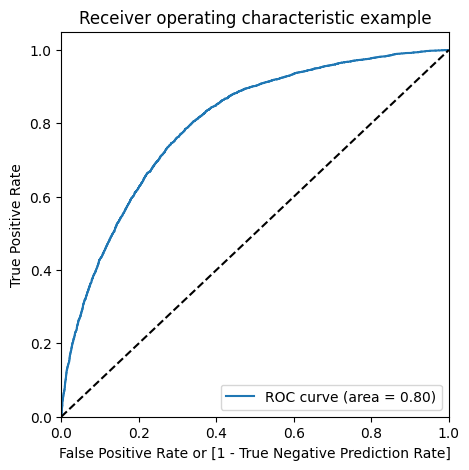

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_sm_pred_final.Converted, y_train_sm_pred_final.Converted_prob, drop_intermediate = False )

draw_roc(y_train_sm_pred_final.Converted, y_train_sm_pred_final.Converted_prob)



In [ ]:
# Let's create columns with different probability cutoffs
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_sm_pred_final[i]= y_train_sm_pred_final.Converted_prob.map(lambda x: 1 if x > i else 0)
y_train_sm_pred_final.head()

,Converted,Converted_prob,churn_pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.781254,1,1,1,1,1,1,1,1,1,0,0
1,0,0.319072,0,1,1,1,1,0,0,0,0,0,0
2,0,0.535830,1,1,1,1,1,1,1,0,0,0,0
3,0,0.105396,0,1,1,0,0,0,0,0,0,0,0
4,0,0.273796,0,1,1,1,0,0,0,0,0,0,0


In [ ]:
cutoff=predict_cutoff(y_train_sm_pred_final)
cutoff

,probability,accuracy,sensitivity,specificity
0.0,0.0,0.500000,1.000000,0.000000
0.1,0.1,0.570231,0.984577,0.155884
0.2,0.2,0.624055,0.964186,0.283925
0.3,0.3,0.673326,0.928475,0.418176
0.4,0.4,0.718042,0.880344,0.555740
0.5,0.5,0.730928,0.777352,0.684505
0.6,0.6,0.708881,0.605631,0.812131
0.7,0.7,0.648639,0.378739,0.918538
0.8,0.8,0.581927,0.191078,0.972777
0.9,0.9,0.543267,0.097298,0.989235


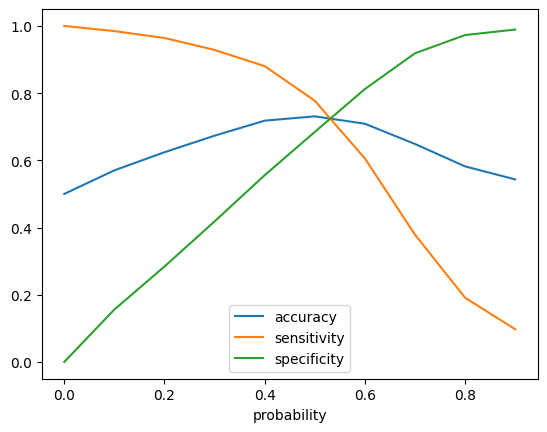

In [ ]:
# plotting accuracy sensitivity and specificity for various probabilities calculated above.
cutoff.plot.line(x='probability', y=['accuracy','sensitivity','specificity'])
plt.show()

The initial cut off assigned was 0.5 , we can see the converging point of all the curves are slightly lesser then 0.6. We can introduce new cut-off by repeating the above execrise with finer granular cut off values . Lets assign 0.54 as new cut-off

In [ ]:
y_train_sm_pred_final['final_churn_pred'] = y_train_sm_pred_final.Converted_prob.map( lambda x: 1 if x > 0.54 else 0)

print("Model overall accuracy:",metrics.accuracy_score(y_train_sm_pred_final.Converted, y_train_sm_pred_final.final_churn_pred))

Model overall accuracy: 0.7276679432770935


Sensitivity =  0.7194907359486595
Specificity =  0.7358451506055274
False Positive Rate =  0.26415484939447265
Precision =  0.7314532252972745
True Negative Prediction Rate =  0.7240044811080558


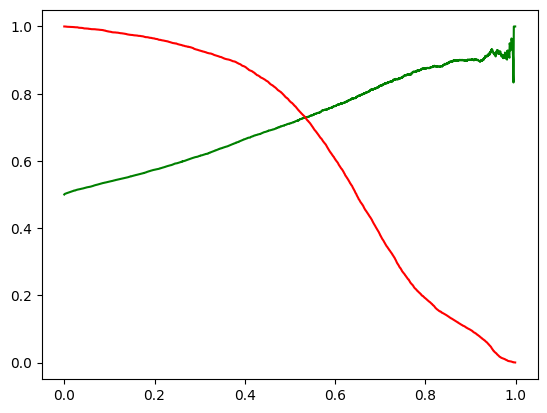

In [ ]:
confusion = metrics.confusion_matrix(y_train_sm_pred_final.Converted, y_train_sm_pred_final.final_churn_pred )
TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
metrics_classification(TP,TN,FP,FN)

#Precision and recall tradeoff¶
p, r, thresholds = precision_recall_curve(y_train_sm_pred_final.Converted, y_train_sm_pred_final.Converted_prob)

# Plotting the curve
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [ ]:

# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(r, p)
print(auc_precision_recall)

0.7807921355784325


Lets validate the model against X_test

In [ ]:
X_test_rfe=X_test[rfe_columns]
X_test_rfe.head()

,arpu_6,roam_og_mou_7,loc_og_t2t_mou_7,loc_og_t2m_mou_7,loc_og_t2f_mou_7,loc_og_mou_7,std_og_mou_6,total_og_mou_7,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_mou_7,std_ic_t2t_mou_6,std_ic_t2f_mou_6,total_ic_mou_7,isd_ic_mou_6,total_rech_num_7,last_day_rch_amt_6,monthly_2g_6,monthly_2g_7,sachet_2g_7,monthly_3g_7,aon,aug_vbc_3g,jun_vbc_3g,total_data_rech_6
13205,0.086295,0.100066,0.009451,0.001435,0.027925,0.012161,0.051469,0.100863,0.006671,0.002828,0.012252,0.002074,0.001318,0.092251,0.000000,0.086957,0.062344,0.0,0.0,0.062500,0.0000,0.584400,0.009653,0.005267,0.000000
6847,0.095192,0.000000,0.005963,0.047857,0.041962,0.037464,0.047211,0.133569,0.075118,0.066324,0.068980,0.015709,0.024589,0.059683,0.000000,0.050725,0.124688,0.0,0.0,0.000000,0.0000,0.838203,0.000000,0.000000,0.000000
2287,0.098096,0.000000,0.030731,0.114043,0.032753,0.099923,0.011832,0.104416,0.100911,0.140818,0.108113,0.017901,0.015496,0.096617,0.000000,0.050725,0.037406,0.0,0.0,0.020833,0.0000,0.738469,0.000000,0.000000,0.000000
7031,0.097282,0.000000,0.000000,0.019550,0.005691,0.012056,0.001000,0.011741,0.026897,0.035840,0.025744,0.000000,0.000000,0.019729,0.001379,0.050725,0.062843,0.0,0.0,0.000000,0.1250,0.154794,0.115275,0.127709,0.004557
3747,0.089834,0.003417,0.001292,0.010842,0.005227,0.008095,0.099521,0.129482,0.013989,0.012265,0.009400,0.007415,0.000000,0.011963,0.000000,0.065217,0.027431,0.0,0.0,0.000000,0.0625,0.297754,0.000053,0.000000,0.000000


In [ ]:
# Adding constant to the test model.
X_test_SM = stats.add_constant(X_test_rfe)
y_test_pred = res.predict(X_test_SM)
print("\n Top ten p value of the prediction:\n",y_test_pred[:10])


 Top ten p value of the prediction:
 13205    0.399865
6847     0.253882
2287     0.104020
7031     0.083148
3747     0.575621
2836     0.397592
8817     0.244265
45       0.068958
7643     0.041992
12412    0.232138
dtype: float64


In [ ]:
y_pred = pd.DataFrame(y_test_pred)
y_pred=y_pred.rename(columns = {0:"Conv_prob"})
y_test_df = pd.DataFrame(y_test)
y_pred_final = pd.concat([y_test_df,y_pred],axis=1)
y_pred_final['test_churn_pred'] = y_pred_final.Conv_prob.map(lambda x: 1 if x>0.54 else 0)
y_pred_final.head()

,churn_probability,Conv_prob,test_churn_pred
13205,0,0.399865,0
6847,0,0.253882,0
2287,0,0.104020,0
7031,0,0.083148,0
3747,0,0.575621,1


Model Evaluation

In [ ]:
# Checking the overall accuracy of the predicted set.
metrics.accuracy_score(y_pred_final.churn_probability, y_pred_final.test_churn_pred)

0.7292202227934875

In [ ]:
# Confusion Matrix
confusion = metrics.confusion_matrix(y_pred_final.churn_probability, y_pred_final.test_churn_pred)
print("Confusion Matrix\n",confusion)

TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

metrics_classification(TP,TN,FP,FN)

print("predicted model accuracy: ",round(metrics.accuracy_score(y_pred_final.churn_probability, y_pred_final.test_churn_pred),2)*100,"%")
print("predicted model sensitivity: ",round(TP / float(TP+FN),2)*100,"%")

Confusion Matrix
 [[2377  844]
 [ 104  176]]
Sensitivity =  0.6285714285714286
Specificity =  0.7379695746662527
False Positive Rate =  0.26203042533374726
Precision =  0.17254901960784313
True Negative Prediction Rate =  0.9580814187827489
predicted model accuracy:  73.0 %
predicted model sensitivity:  63.0 %


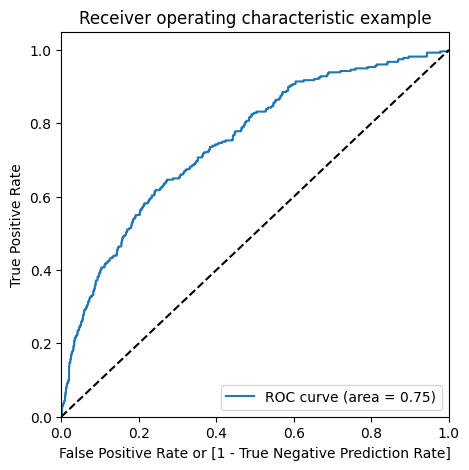

In [ ]:
# ROC curve for the test dataset

# Defining the variables to plot the curve
fpr, tpr, thresholds = metrics.roc_curve(y_pred_final.churn_probability,y_pred_final.Conv_prob, drop_intermediate = False )
# Plotting the curve for the obtained metrics
draw_roc(y_pred_final.churn_probability,y_pred_final.Conv_prob)

The baseline model performance is not at par but its a good start without PCA, lets perform PCA and use the features for logistic regression to check whether the model performance is better than the current Logistic regressionmodel

#Logistic Regression with PCA

In [ ]:
X_train.shape

(10501, 93)

In [ ]:
X_train.head()

,arpu_6,arpu_7,onnet_mou_6,onnet_mou_7,offnet_mou_6,offnet_mou_7,roam_ic_mou_6,roam_ic_mou_7,roam_og_mou_6,roam_og_mou_7,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_mou_6,loc_og_mou_7,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_mou_6,std_og_mou_7,isd_og_mou_6,isd_og_mou_7,spl_og_mou_6,spl_og_mou_7,og_others_6,og_others_7,total_og_mou_6,total_og_mou_7,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_mou_6,loc_ic_mou_7,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_mou_6,std_ic_mou_7,total_ic_mou_6,total_ic_mou_7,spl_ic_mou_6,spl_ic_mou_7,isd_ic_mou_6,isd_ic_mou_7,ic_others_6,ic_others_7,total_rech_num_6,total_rech_num_7,max_rech_amt_6,max_rech_amt_7,last_day_rch_amt_6,last_day_rch_amt_7,max_rech_data_6,max_rech_data_7,vol_2g_mb_6,vol_2g_mb_7,vol_3g_mb_6,vol_3g_mb_7,night_pck_user_6,night_pck_user_7,monthly_2g_6,monthly_2g_7,sachet_2g_6,sachet_2g_7,monthly_3g_6,monthly_3g_7,sachet_3g_6,sachet_3g_7,fb_user_6,fb_user_7,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_data_rech_6,total_data_rech_7,amt_data_6,amt_data_7,av_amt_data_6_7
596,0.099884,0.036437,0.003729,0.000105,0.003735,0.000033,0.000000,0.000000,0.000000,0.000000,0.004515,0.000109,0.006383,0.000050,0.0,0.000000,0.0,0.0,0.009343,0.000137,0.000000,0.000000,0.000149,0.000000,0.0,0.000000,0.000147,0.000000,0.000000,0.0,0.000010,0.000000,0.000000,0.0,0.006922,0.000128,0.004638,0.005052,0.018678,0.011333,0.000823,0.000000,0.014019,0.011264,0.000000,0.000000,0.000376,0.000426,0.0,0.000000,0.000346,0.000219,0.014306,0.009111,0.020749,0.0,0.000000,0.000000,0.006981,0.004205,0.076471,0.028986,0.062843,0.014194,0.007481,0.014194,0.162058,0.000000,0.004969,0.000000,0.054272,0.000000,0.5,0.0,0.00,0.0,0.00000,0.000000,0.222222,0.0,0.000000,0.000000,1.0,0.0,0.159382,0.000000,0.000000,0.087512,0.018229,0.000000,0.032178,0.000785,0.008004
13381,0.099999,0.053610,0.010145,0.016118,0.057996,0.063694,0.023576,0.021873,0.047326,0.064146,0.004339,0.008609,0.036095,0.063215,0.0,0.002721,0.0,0.0,0.031850,0.046052,0.005461,0.002873,0.017797,0.002787,0.0,0.010584,0.022318,0.005909,0.000005,0.0,0.000195,0.005562,0.080313,0.0,0.045991,0.048946,0.003898,0.010300,0.026564,0.037561,0.000000,0.000284,0.018142,0.033304,0.001293,0.003372,0.004610,0.024438,0.0,0.000423,0.005240,0.014999,0.021456,0.039583,0.027328,0.0,0.000014,0.001097,0.015583,0.004091,0.111765,0.130435,0.027431,0.035484,0.010973,0.016129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.745472,0.000000,0.000000,0.000000,0.000000,0.000000,0.015588,0.013732,0.004851
5190,0.080474,0.039642,0.000000,0.000579,0.001122,0.002574,0.000000,0.000000,0.000000,0.000000,0.000000,0.000605,0.001997,0.003978,0.0,0.000000,0.0,0.0,0.001524,0.002946,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.001580,0.000000,0.0,0.001105,0.002992,0.000319,0.001092,0.025005,0.031944,0.000218,0.001310,0.015157,0.023679,0.000000,0.000000,0.000000,0.000000,0.0,0.009621,0.000000,0.001620,0.014691,0.019472,0.000000,0.0,0.000168,0.000000,0.000000,0.000000,0.017647,0.036232,0.037905,0.049032,0.037905,0.049032,0.097749,0.097749,0.000053,0.000051,0.008275,0.023325,0.5,0.5,0.00,0.0,0.02381,0.020833,0.000000,0.0,0.034483,0.030303,1.0,1.0,0.228689,0.004717,0.000000,0.000000,0.010995,0.011038,0.013652,0.014088,0.003611
448,0.082108,0.045180,0.003214,0.001390,0.005167,0.015831,0.000000,0.000000,0.000000,0.000000,0.003891,0.001454,0.005634,0.021222,0.0,0.000000,0.0,0.0,0.008155,0.014004,0.000000,0.000000,0.002013,0.001036,0.0,0.001095,0.001985,0.000947,0.000000,0.0,0.000000,0.007071,0.000000,0.0,0.007885,0.014978,0.030003,0.033983,0.020976,0.021304,0.015578,0.010637,0.032958,0.038717,0.0

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(random_state=42)
pca.fit(X_train)
pca.components_

array([[ 6.96707506e-03,  5.55414193e-03,  3.60699319e-02, ...,
        -7.68755718e-03, -1.03747372e-02, -1.38333118e-02],
       [ 6.61168873e-03, -3.10170674e-03,  8.67450072e-03, ...,
         1.26761636e-02, -1.32688483e-02, -1.41912926e-04],
       [ 2.45763077e-03,  1.07514296e-03, -4.08482219e-02, ...,
        -8.28492833e-03, -9.91108454e-03, -1.39487654e-02],
       ...,
       [-6.16173991e-07,  1.61656117e-06,  2.64552752e-07, ...,
         1.50155167e-06, -1.69486536e-06, -1.09827547e-07],
       [-2.70598527e-07,  7.00835380e-07,  6.32165093e-07, ...,
         1.77744258e-08, -4.29748131e-07, -3.10857347e-07],
       [-0.00000000e+00, -1.79732498e-15, -7.09632910e-17, ...,
        -5.28232011e-01, -5.11882798e-01,  6.77456230e-01]])

Looking at the explained variance ratio for each component

In [ ]:
pca.explained_variance_ratio_

array([5.77474109e-01, 1.11000387e-01, 6.61510249e-02, 3.94806313e-02,
       2.48735720e-02, 2.12752901e-02, 1.90843399e-02, 1.73497518e-02,
       9.73449058e-03, 9.25736787e-03, 8.78785427e-03, 7.87079054e-03,
       6.62553286e-03, 5.79053774e-03, 4.99777636e-03, 4.49486926e-03,
       3.96473332e-03, 3.83844952e-03, 3.63597509e-03, 3.44628589e-03,
       3.15937438e-03, 2.82446758e-03, 2.79587166e-03, 2.72927388e-03,
       2.47060535e-03, 2.35983067e-03, 2.27355865e-03, 2.15853318e-03,
       1.98576967e-03, 1.93129165e-03, 1.80457098e-03, 1.71474637e-03,
       1.47922058e-03, 1.26965489e-03, 1.21783588e-03, 1.19627614e-03,
       1.11307420e-03, 1.00873581e-03, 9.43123555e-04, 9.37011213e-04,
       8.69162531e-04, 8.21537775e-04, 8.07995352e-04, 7.59655414e-04,
       6.83633909e-04, 6.45156448e-04, 6.33720831e-04, 6.18737852e-04,
       6.00971849e-04, 5.88603781e-04, 5.61997718e-04, 5.45425568e-04,
       5.38777627e-04, 5.36325782e-04, 3.98535511e-04, 3.94409989e-04,
      

Making a scree plot for the explained variance

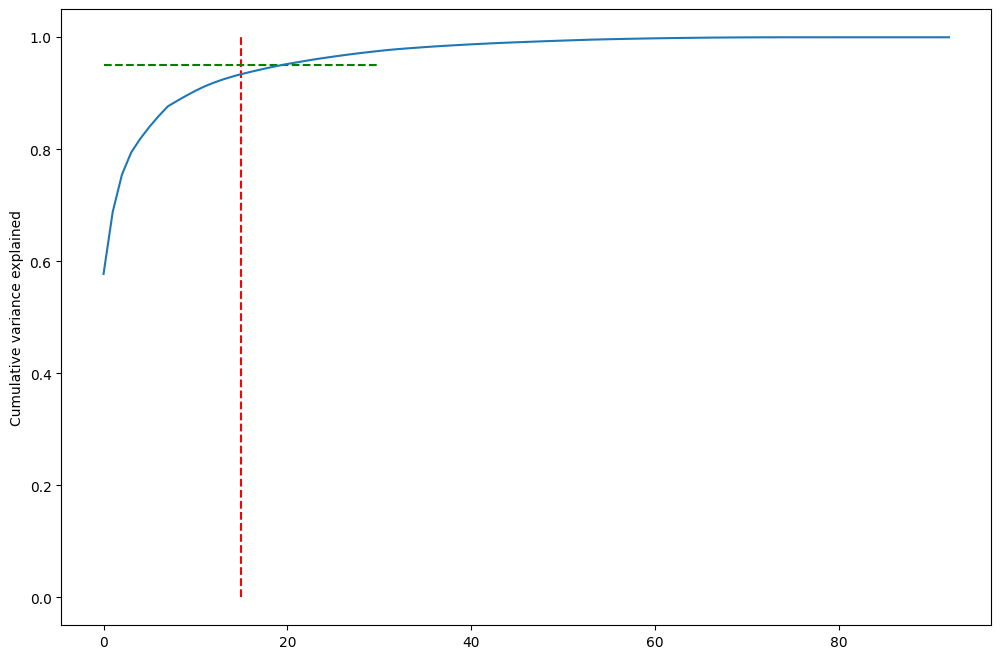

In [ ]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize=[12,8])
plt.vlines(x=15, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

Lets Perform PCA with 16 components & use IncrementalPCA this time

In [ ]:
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=16)
df_train_pca = pca_final.fit_transform(X_train)
print(df_train_pca.shape)
corrmat = np.corrcoef(df_train_pca.transpose())
print(corrmat.shape)


(10501, 16)
(16, 16)


Plotting the heatmap of the corr matrix

<Axes: >

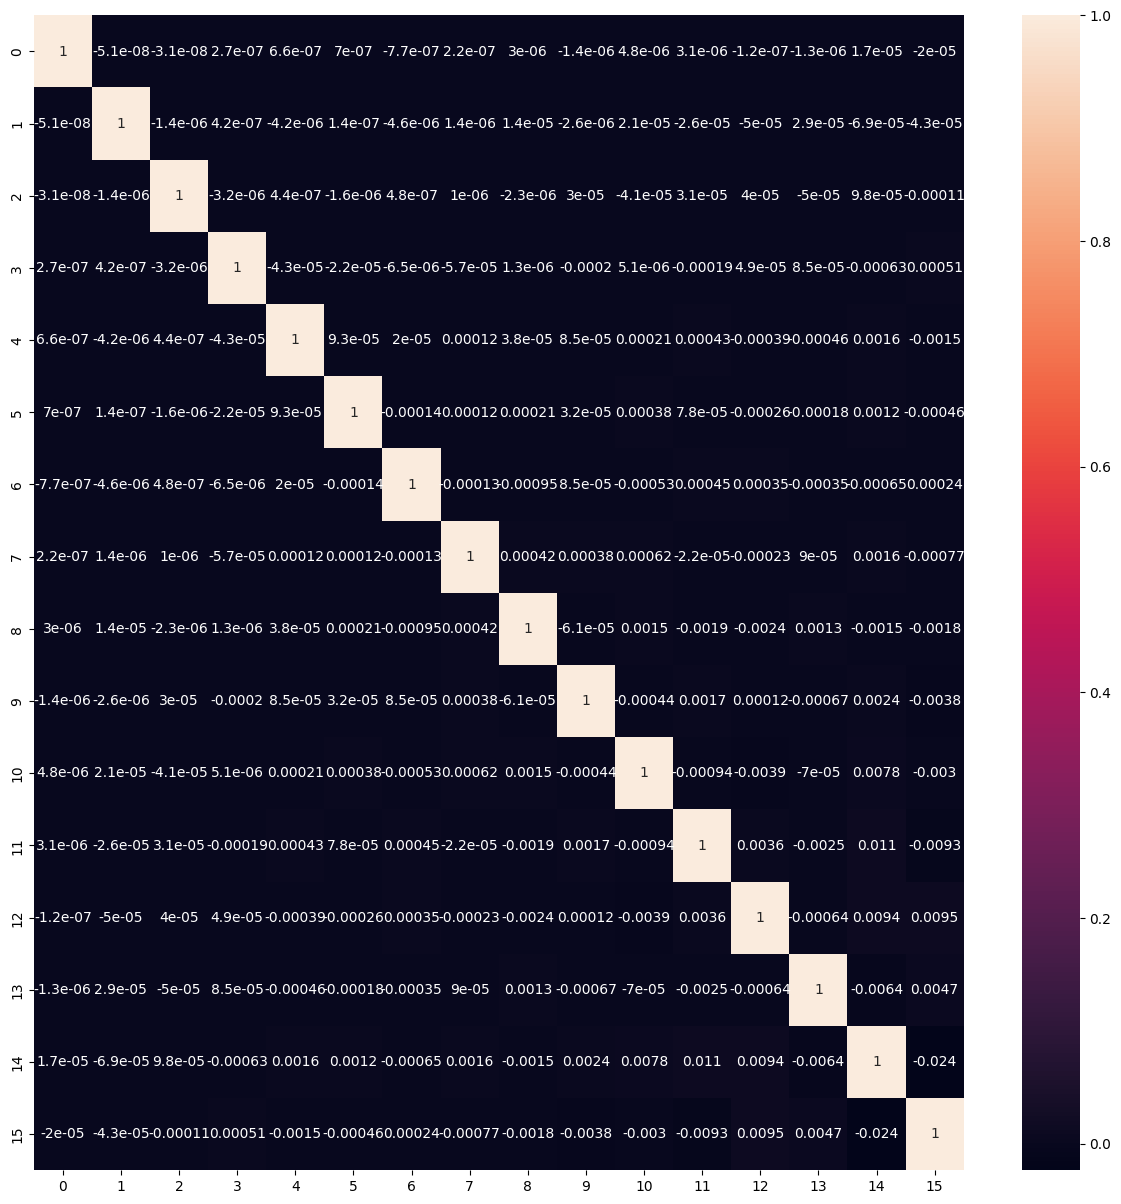

In [ ]:
plt.figure(figsize=[15,15])
sns.heatmap(corrmat, annot=True)

Applying the transformation on the test set

In [ ]:
X_test.shape

(3501, 93)

In [ ]:
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(3501, 16)

### Applying logistic regression on the data on our Principal components

In [ ]:
learner_pca = LogisticRegression()
model_pca = learner_pca.fit(df_train_pca, y_train)
pred_probs_test = model_pca.predict_proba(df_test_pca)
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test[:,1]))

'0.71'

Model Evaluation


Evaluation on Train Set

In [ ]:
pred_probs_train = model_pca.predict(df_train_pca)
confusion = metrics.confusion_matrix(y_train, pred_probs_train)
TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
metrics_classification(TP,TN,FP,FN)
print("Accuracy:",metrics.accuracy_score(y_train, pred_probs_train))


Sensitivity =  0.008333333333333333
Specificity =  0.9997929820929511
False Positive Rate =  0.00020701790704895975
Precision =  0.7777777777777778
True Negative Prediction Rate =  0.9206061761341975
Accuracy: 0.9204837634511


Evaluation on Test Set

In [ ]:
pred_probs_test1 = model_pca.predict(df_test_pca)
confusion = metrics.confusion_matrix(y_test, pred_probs_test1)
TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
metrics_classification(TP,TN,FP,FN)

Sensitivity =  0.0035714285714285713
Specificity =  0.999689537410742
False Positive Rate =  0.0003104625892579944
Precision =  0.5
True Negative Prediction Rate =  0.9202629322663618


In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, pred_probs_test1))


Accuracy: 0.9200228506141103


#Its Evident with PCA Logistic Regression Accuracy is improved till 92% & there is no variance between train and test accuracy scores

Making it a little more unsupervised


In [ ]:
pca_again = PCA(0.95)
df_train_pca2 = pca_again.fit_transform(X_train)
print(df_train_pca2.shape)
df_test_pca2 = pca_again.transform(X_test)
print(df_test_pca2.shape)

(10501, 21)
(3501, 21)


In [ ]:
learner_pca2 = LogisticRegression()
model_pca2 = learner_pca2.fit(df_train_pca2, y_train)
pred_probs_test2 = model_pca2.predict_proba(df_test_pca2)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test2))

'0.72'

In [ ]:
pca_again.components_

array([[ 6.96707506e-03,  5.55414193e-03,  3.60699319e-02, ...,
        -7.68755718e-03, -1.03747372e-02, -1.38333118e-02],
       [ 6.61168873e-03, -3.10170674e-03,  8.67450072e-03, ...,
         1.26761636e-02, -1.32688483e-02, -1.41912926e-04],
       [ 2.45763077e-03,  1.07514296e-03, -4.08482219e-02, ...,
        -8.28492833e-03, -9.91108454e-03, -1.39487654e-02],
       ...,
       [ 4.16391358e-02,  1.90705613e-02,  6.53561536e-02, ...,
         1.49419242e-01,  8.85384034e-02,  1.83405668e-01],
       [ 6.04314037e-03,  3.94205048e-03,  7.01833877e-02, ...,
        -5.76417678e-02, -2.37825108e-02, -6.29148913e-02],
       [ 3.53271333e-02,  7.79496957e-03, -4.36022577e-03, ...,
         3.26098280e-02, -1.13922651e-01, -6.06526125e-02]])

Evaluation on Train set


In [ ]:
pred_probs_train2 = model_pca2.predict(df_train_pca2)
confusion = metrics.confusion_matrix(y_train, pred_probs_train2)
TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
metrics_classification(TP,TN,FP,FN)
print("Accuracy:",metrics.accuracy_score(y_train, pred_probs_train2))

Sensitivity =  0.009523809523809525
Specificity =  0.9996894731394266
False Positive Rate =  0.0003105268605734396
Precision =  0.7272727272727273
True Negative Prediction Rate =  0.9206863679694948
Accuracy: 0.9204837634511


Evaluation on Test set


In [ ]:
pred_probs_test2 = model_pca2.predict(df_test_pca2)
confusion = metrics.confusion_matrix(y_test, pred_probs_test2)
TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
metrics_classification(TP,TN,FP,FN)
print("Accuracy:",metrics.accuracy_score(y_test, pred_probs_test2))

Sensitivity =  0.0035714285714285713
Specificity =  0.999379074821484
False Positive Rate =  0.0006209251785159888
Precision =  0.3333333333333333
True Negative Prediction Rate =  0.9202401372212693
Accuracy: 0.9197372179377321


In [ ]:
y_test.value_counts()

churn_probability
0    3221
1     280
Name: count, dtype: int64

#SVM

In [ ]:
# using rbf kernel, C=1, default value of gamma

model = SVC(C = 1, kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Model Evaluation Metrics


In [ ]:
confusion_matrix(y_true=y_test, y_pred=y_pred)
# accuracy
print("accuracy", metrics.accuracy_score(y_test, y_pred))

# precision
print("precision", metrics.precision_score(y_test, y_pred))

# recall/sensitivity
print("recall", metrics.recall_score(y_test, y_pred))

accuracy 0.9200228506141103
precision 0.0
recall 0.0


#Hyperparameter Tuning
Now, we have multiple hyperparameters to optimise -

The choice of kernel (linear, rbf etc.)
C
gamma
We'll use the GridSearchCV() method to tune the hyperparameters.

#Grid Search to Find Optimal Hyperparameters
Let's first use the RBF kernel to find the optimal C and gamma (we can consider the kernel as a hyperparameter as well, though training the model will take an exorbitant amount of time).

In [ ]:
# creating a KFold object with 5 splits
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]


# specify model
model = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv_svm = GridSearchCV(estimator = model,
                        param_grid = hyper_params,
                        scoring= 'accuracy',
                        cv = folds,
                        verbose = 1,
                        return_train_score=True)

# fit the model
model_cv_svm.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


KeyboardInterrupt: 

In [ ]:
# cv results
cv_results = pd.DataFrame(model_cv_svm.cv_results_)
cv_results

In [ ]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv_svm.best_score_
best_hyperparams = model_cv_svm.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

Building and Evaluating the Final SVM Model


In [ ]:

# model
model_svm = SVC(C=1, gamma=0.01, kernel="rbf")

model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)

# metrics
print(metrics.confusion_matrix(y_test, y_pred_svm), "\n")
print("accuracy", metrics.accuracy_score(y_test, y_pred_svm))
print("precision", metrics.precision_score(y_test, y_pred_svm))
print("sensitivity/recall", metrics.recall_score(y_test, y_pred_svm))

#XGBoost Classifier with Hyper Parameter Tuning

Hyperopt is used since the other HPT techniques were throttling and not performing well

In [ ]:
import xgboost as xgb
from hyperopt import STATUS_OK

train_dmatrix = xgb.DMatrix(data=X_train, label=y_train)

N_FOLDS = 5

# define objective to minimize
def objective(params, n_folds = N_FOLDS):
    params['objective'] = 'binary:logistic'
    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=train_dmatrix, params=params,
                  nfold=n_folds, num_boost_round=10000, early_stopping_rounds=100,
                  metrics="auc", as_pandas=True, seed=123)

    # Print the accuracy
    loss = 1 - cv_results["test-auc-mean"].iloc[-1]
    n_estimators = cv_results["test-auc-mean"].idxmax() + 1
    return {'loss': loss, 'params': params, 'n_estimators': n_estimators, 'status': STATUS_OK}

In [ ]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import Trials

hyperparameter_space = {
    'n_jobs': -1,
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'min_child_weight': hp.quniform('min_child_weight', 1, 7, 2),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'max_depth': hp.randint('max_depth', 1,16),
    'gamma': hp.uniform('gamma', 0.1,0.4),
    'max_delta_step': hp.randint('max_delta_step',0,10),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2))
}


bayes_trials = Trials()

In [ ]:
from hyperopt import fmin
from hyperopt import tpe

MAX_EVALS = 50

best = fmin(fn = objective, space = hyperparameter_space, algo = tpe.suggest, max_evals = MAX_EVALS,
           trials = bayes_trials, rstate = np.random.default_rng(seed=42))
best

 64%|██████▍   | 32/50 [12:16<07:28, 24.94s/trial, best loss: 0.19650218804602204]

In [ ]:
# best['num_boost_round']=10000
# best['early_stopping_rounds']=100

xgb_best = xgb.XGBClassifier(**best)

xgb_best.fit(X_train, y_train)

NameError: name 'xgb' is not defined

In [ ]:
# Import roc_curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def add_roc_plot(model, test_x, test_y, legend_text):
    y_pred_prob = model.predict_proba(test_x)[:, 1]
    # Calculate the roc metrics
    fpr, tpr, thresholds = roc_curve(test_y, y_pred_prob)
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=legend_text)
    plt.legend()


models_list = [xgb_best]
model_names = ['Extreme Gradient Boosting']

plt.figure(figsize=(6, 6))
[add_roc_plot(model, X_test, y_test, legend_text) for model, legend_text in zip(models_list, model_names)]

# Add labels and diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot([0, 1], [0, 1], "k-")
plt.show()

NameError: name 'xgb_best' is not defined

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score

list_scores = [roc_auc_score, recall_score, precision_score, accuracy_score]
calc_scores = []
def compute_scores(model, x_test, y_test, scores):
    return [round(score(y_test, model.predict(x_test)), 2) for score in scores]

[calc_scores.append(compute_scores(model, X_test, y_test, list_scores)) for model in models_list]

score_names = ['roc_auc', 'recall', 'precision', 'accuracy']
scores_df = pd.DataFrame(calc_scores, columns=score_names, index=model_names)

scores_df

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(12,10))
xgb.plot_importance(xgb_best, ax = ax)
plt.show()

#Random forest with PCA


In [ ]:
from sklearn.ensemble import RandomForestClassifier

max_features = int(round(np.sqrt(X_train.shape[1])))    # number of variables to consider to split each node
print(max_features)

rf = RandomForestClassifier(n_estimators=100, max_depth=4, max_features=7, random_state=100, oob_score=True, verbose=1)

rf.fit(df_train_pca, y_train)

In [ ]:
rf.oob_score_

#HPT

In [ ]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2,3,5],
    'min_samples_leaf': [50,100],
    'min_samples_split': [ 100, 150, ],
    'n_estimators': [100, 200 ]
}
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")
grid_search.fit(df_train_pca, y_train)


In [ ]:
grid_search.best_score_

In [ ]:
grid_search.best_params_

In [ ]:
rfc_model = RandomForestClassifier(bootstrap=True,
                             max_depth=5,
                             min_samples_leaf=50,
                             min_samples_split=100,
                             n_estimators=200)
rfc_model.fit(df_train_pca, y_train)
evaluate_model(rfc_model)

NameError: name 'accuracy_score' is not defined

In [ ]:
rfc_model.feature_importances_

#The accuracy of XGBOOST and Logistic Regression with PCA is same on the Training dataset , we can apply both on the test.csv (unseen data) to see which one gives better performance & the same can be finalised as a best model

In [ ]:
churn_test.head(2) # Test.CSV is loaded and all the pre-processing is applied in advance

,arpu_6,arpu_7,onnet_mou_6,onnet_mou_7,offnet_mou_6,offnet_mou_7,roam_ic_mou_6,roam_ic_mou_7,roam_og_mou_6,roam_og_mou_7,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_mou_6,loc_og_mou_7,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_mou_6,std_og_mou_7,isd_og_mou_6,isd_og_mou_7,spl_og_mou_6,spl_og_mou_7,og_others_6,og_others_7,total_og_mou_6,total_og_mou_7,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_mou_6,loc_ic_mou_7,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_mou_6,std_ic_mou_7,total_ic_mou_6,total_ic_mou_7,spl_ic_mou_6,spl_ic_mou_7,isd_ic_mou_6,isd_ic_mou_7,ic_others_6,ic_others_7,total_rech_num_6,total_rech_num_7,max_rech_amt_6,max_rech_amt_7,last_day_rch_amt_6,last_day_rch_amt_7,max_rech_data_6,max_rech_data_7,vol_2g_mb_6,vol_2g_mb_7,vol_3g_mb_6,vol_3g_mb_7,night_pck_user_6,night_pck_user_7,monthly_2g_6,monthly_2g_7,sachet_2g_6,sachet_2g_7,monthly_3g_6,monthly_3g_7,sachet_3g_6,sachet_3g_7,fb_user_6,fb_user_7,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_data_rech_6,total_data_rech_7,amt_data_6,amt_data_7,av_amt_data_6_7
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69999,91.882,65.330,31.78,20.23,60.16,32.16,0.0,0.0,0.0,0.0,24.88,20.23,18.13,10.89,0.00,13.58,0.0,0.0,43.01,44.71,6.9,0.0,42.03,7.68,0.0,0.0,48.93,7.68,0.0,0.0,0.0,0.0,0.0,0.0,91.94,52.39,30.33,37.56,10.21,4.59,0.26,0.0,40.81,42.16,0.0,0.0,0.36,1.04,0.0,0.0,0.36,1.04,41.73,43.56,0.54,0.34,0.00,0.00,0.0,0.0,5,5,50,30,30,30,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0,0,0,0,0,0,0,0,-1.0,-1.0,1692,0.0,0.0,0.0,0.0,0.0,103.0,90.0,96.5
70000,414.168,515.568,75.51,41.21,474.34,621.84,0.0,0.0,0.0,0.0,75.51,41.21,473.61,598.08,0.73,0.00,0.0,0.0,549.86,639.29,0.0,0.0,0.00,23.76,0.0,0.0,0.00,23.76,0.0,0.0,0.0,0.0,0.0,0.0,549.86,663.06,19.99,26.95,160.19,122.29,1.49,0.0,181.69,149.24,0.0,0.0,0.00,12.51,0.0,0.0,0.00,12.51,296.33,339.64,0.00,0.00,114.63,177.88,0.0,0.0,5,4,250,250,250,0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0,0,0,0,0,0,0,0,-1.0,-1.0,2533,0.0,0.0,0.0,0.0,0.0,500.0,500.0,500.0


In [ ]:
churn_test.shape

(30000, 93)

In [ ]:
churn_test_xgb=churn_test[X_train.columns.to_list()]

In [ ]:
churn_test_xgb.shape

(30000, 93)

In [ ]:
X_test.shape

(3501, 93)

In [ ]:
xgboost_prediction=xgb_best.predict(churn_test_xgb)

NameError: name 'xgb_best' is not defined

In [ ]:
xgboost_prediction[:50]

NameError: name 'xgboost_prediction' is not defined

In [ ]:
print(len(xgboost_prediction))
print(len(churn_test_id))

NameError: name 'xgboost_prediction' is not defined

#Prediction file by XGB without PCA

In [ ]:
final_prediction = pd.DataFrame({'id':churn_test_id,'churn_probability':xgboost_prediction})
final_prediction.to_csv('/kaggle/working/xgb_nopca.csv',index=False)
print(final_prediction)

In [ ]:
df_unseen_pca = pca_final.transform(churn_test[X_train.columns.to_list()])

log_reg_pca_pred = model_pca.predict(df_unseen_pca)

#Prediction file by Logistic Regression with Incremental PCA

In [ ]:
final_prediction = pd.DataFrame({'id':churn_test_id,'churn_probability':log_reg_pca_pred})
final_prediction.to_csv('/kaggle/working/lr_incre_pca.csv',index=False)
print(final_prediction)

#Prediction file by Random Forest with PCA

In [ ]:
rf_pca_pred=rfc_model.predict(df_unseen_pca)
final_prediction = pd.DataFrame({'id':churn_test_id,'churn_probability':rf_pca_pred})
final_prediction.to_csv('/kaggle/working/rf_pca.csv',index=False)
print(final_prediction)

NameError: name 'rfc_model' is not defined

#Prediction file by Logistic Regression with PCA of 95% variance

In [ ]:
df_unseen_pca = pca_again.transform(churn_test[X_train.columns.to_list()])

log_reg_pca_pred = model_pca2.predict(df_unseen_pca)

final_prediction = pd.DataFrame({'id':churn_test_id,'churn_probability':log_reg_pca_pred})
final_prediction.to_csv('/kaggle/working/lr_pca_variance.csv',index=False)
print(final_prediction)

#Prediction file by SVM

In [ ]:
svm_pred=model_svm.predict(churn_test[X_train.columns.to_list()])
final_prediction = pd.DataFrame({'id':churn_test_id,'churn_probability':svm_pred})
final_prediction.to_csv('/kaggle/working/svm.csv',index=False)
print(final_prediction)

#Conclusion and Observations

The different Models which are tried are
- Logistic Regression with and without PCA
- XGBOOST
- Random Forest with PCA
- SVM

- The logistic regression is considered as a baseline model with an accuracy of 72%
- All the other models yieled an accuracy of 92%
- The final two model chosen are XGBOOST and Random Forest
- The top 10 features demonstrated in the feature importance chart of the  Random forest are the key variables which decides the churn

